#### Imports

La idea de esta variante, es predecir solamente los productos que tengan mas de 12 meses de datos (usando los ultimos 12 solamente), y aquellos con menos datos, predecir la media

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from skopt import BayesSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.metrics import MeanSquaredError
from keras.regularizers import l2
from keras.layers import BatchNormalization
from skopt.space import Categorical
from sklearn.metrics import mean_squared_error
import json

In [255]:
final_dataset = pd.read_csv('../../Datasets/final_dataset.csv', sep='\t')

In [256]:
final_dataset.head()

,periodo,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,y,cat1,cat2,cat3,brand,sku_size,stock_final,close_quarter,age
0,201701,20001,0,479,937.72717,934.77222,HC,ROPA LAVADO,Liquido,ARIEL,3000,NaN,0,0
1,201702,20001,0,432,833.72187,798.01620,HC,ROPA LAVADO,Liquido,ARIEL,3000,NaN,0,1
2,201703,20001,0,509,1330.74697,1303.35771,HC,ROPA LAVADO,Liquido,ARIEL,3000,NaN,1,2
3,201704,20001,0,279,1132.94430,1069.96130,HC,ROPA LAVADO,Liquido,ARIEL,3000,NaN,0,3
4,201705,20001,0,701,1550.68936,1502.20132,HC,ROPA LAVADO,Liquido,ARIEL,3000,NaN,0,4


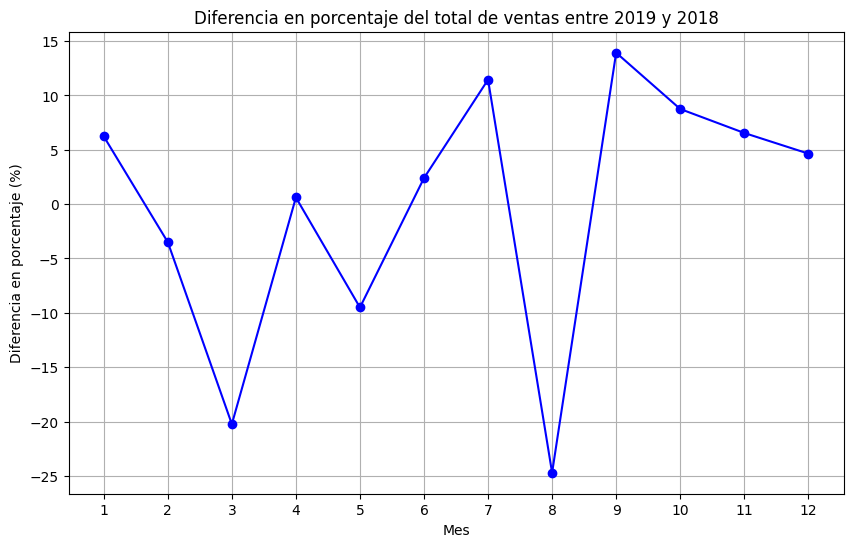

Mes 1: 6.23%
Mes 2: -3.50%
Mes 3: -20.24%
Mes 4: 0.61%
Mes 5: -9.50%
Mes 6: 2.40%
Mes 7: 11.45%
Mes 8: -24.71%
Mes 9: 13.93%
Mes 10: 8.75%
Mes 11: 6.55%
Mes 12: 4.65%


In [270]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
final_dataset = pd.read_csv('../../Datasets/final_dataset.csv', sep='\t')
final_dataset['periodo'] = pd.to_datetime(final_dataset['periodo'], format='%Y%m')

# Filtrar los datos para los años 2018 y 2019
data_2018 = final_dataset[final_dataset['periodo'].dt.year == 2018]
data_2019 = final_dataset[final_dataset['periodo'].dt.year == 2019]

# Agrupar por mes y calcular el total de ventas para cada mes
ventas_2018 = data_2018.groupby(data_2018['periodo'].dt.month)['y'].sum()
ventas_2019 = data_2019.groupby(data_2019['periodo'].dt.month)['y'].sum()

# Asegurarse de que ambos años tienen datos para todos los meses
ventas_2018 = ventas_2018.reindex(range(1, 13), fill_value=0)
ventas_2019 = ventas_2019.reindex(range(1, 13), fill_value=0)

# Calcular la diferencia en porcentaje
diferencia_porcentaje = ((ventas_2019 - ventas_2018) / ventas_2018) * 100

# Configurar el gráfico
plt.figure(figsize=(10, 6))
plt.plot(diferencia_porcentaje.index, diferencia_porcentaje, marker='o', linestyle='-', color='b')
plt.title('Diferencia en porcentaje del total de ventas entre 2019 y 2018')
plt.xlabel('Mes')
plt.ylabel('Diferencia en porcentaje (%)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

for mes in diferencia_porcentaje.index:
    print(f'Mes {mes}: {diferencia_porcentaje[mes]:.2f}%')


Diferencia positiva, significa que en 2019 se vendio mas que en 2018 para ese mes

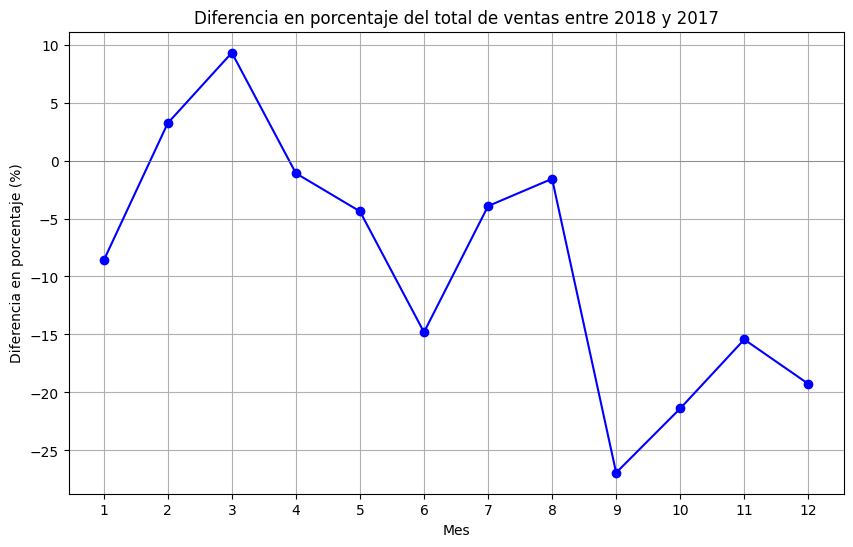

Mes 1: -8.61%
Mes 2: 3.23%
Mes 3: 9.30%
Mes 4: -1.10%
Mes 5: -4.38%
Mes 6: -14.81%
Mes 7: -3.93%
Mes 8: -1.58%
Mes 9: -26.92%
Mes 10: -21.38%
Mes 11: -15.43%
Mes 12: -19.26%


In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
final_dataset = pd.read_csv('../../Datasets/final_dataset.csv', sep='\t')
final_dataset['periodo'] = pd.to_datetime(final_dataset['periodo'], format='%Y%m')

# Filtrar los datos para los años 2017 y 2018
data_2017 = final_dataset[final_dataset['periodo'].dt.year == 2017]
data_2018 = final_dataset[final_dataset['periodo'].dt.year == 2018]

# Agrupar por mes y calcular el total de ventas para cada mes
ventas_2017 = data_2017.groupby(data_2017['periodo'].dt.month)['y'].sum()
ventas_2018 = data_2018.groupby(data_2018['periodo'].dt.month)['y'].sum()

# Asegurarse de que ambos años tienen datos para todos los meses
ventas_2017 = ventas_2017.reindex(range(1, 13), fill_value=0)
ventas_2018 = ventas_2018.reindex(range(1, 13), fill_value=0)

# Calcular la diferencia en porcentaje
diferencia_porcentaje = ((ventas_2018 - ventas_2017) / ventas_2017) * 100

# Configurar el gráfico
plt.figure(figsize=(10, 6))
plt.plot(diferencia_porcentaje.index, diferencia_porcentaje, marker='o', linestyle='-', color='b')
plt.title('Diferencia en porcentaje del total de ventas entre 2018 y 2017')
plt.xlabel('Mes')
plt.ylabel('Diferencia en porcentaje (%)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5)  # Línea horizontal en el 0 para referencia
plt.show()

# Imprimir resultados
for mes in diferencia_porcentaje.index:
    print(f'Mes {mes}: {diferencia_porcentaje[mes]:.2f}%')


In [274]:
import pandas as pd

# Cargar el dataset
final_dataset = pd.read_csv('../../Datasets/final_dataset.csv', sep='\t')
final_dataset['periodo'] = pd.to_datetime(final_dataset['periodo'], format='%Y%m')

# Filtrar los datos para diciembre 2017 y enero 2018
diciembre_2017 = final_dataset[(final_dataset['periodo'].dt.year == 2017) & (final_dataset['periodo'].dt.month == 12)]
enero_2018 = final_dataset[(final_dataset['periodo'].dt.year == 2018) & (final_dataset['periodo'].dt.month == 1)]

# Calcular el total de ventas para diciembre 2017 y enero 2018
total_ventas_diciembre_2017 = diciembre_2017['y'].sum()
total_ventas_enero_2018 = enero_2018['y'].sum()

# Calcular la diferencia en porcentaje
diferencia_porcentaje_diciembre_enero = ((total_ventas_enero_2018 - total_ventas_diciembre_2017) / total_ventas_diciembre_2017) * 100

print(f"Diferencia en porcentaje del total de ventas entre diciembre 2017 y enero 2018: {diferencia_porcentaje_diciembre_enero:.2f}%")


Diferencia en porcentaje del total de ventas entre diciembre 2017 y enero 2018: -16.48%


#### Pre procesamiento

In [ ]:
final_dataset['periodo'] = pd.to_datetime(final_dataset['periodo'], format='%Y%m')


In [ ]:
# Promediamos las vtas de agosto, como las de julio y setpiembre
july_september_data = final_dataset[
    final_dataset['periodo'].isin([pd.Timestamp('2019-07-01'), pd.Timestamp('2019-09-01')])
]

# Agrupar por producto y calcular el promedio
august_average = july_september_data.groupby('product_id')['y'].mean().reset_index()
august_average['periodo'] = pd.Timestamp('2019-08-01')

# Reemplazar los valores de agosto en el DataFrame original
final_dataset = final_dataset.set_index(['product_id', 'periodo'])
final_dataset.update(august_average.set_index(['product_id', 'periodo']))
final_dataset = final_dataset.reset_index()

In [ ]:
# Agreog el MES del quarter, en vez de si es close_quarter
final_dataset['month'] = final_dataset['periodo'].dt.month

def month_in_quarter(month):
    if month in [1, 4, 7, 10]:
        return 1  # Primer mes del trimestre
    elif month in [2, 5, 8, 11]:
        return 2  # Segundo mes del trimestre
    elif month in [3, 6, 9, 12]:
        return 3  # Tercer mes del trimestre

final_dataset['month_in_quarter'] = final_dataset['month'].apply(month_in_quarter)

# Remover la columna 'month' si no es necesaria
final_dataset = final_dataset.drop(columns=['month'])

In [ ]:
columns = ['plan_precios_cuidados', 'cust_request_qty', 'cust_request_tn', 'month_in_quarter', 'brand', 'sku_size', 'cat1', 'cat2', 'cat3','y'] #'close_quarter'
non_scalable_columns = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'plan_precios_cuidados', 'month_in_quarter'] # 'close_quarter'
n_features = len(columns)

Valido el promedio de agosto (este es el mes en que la empresa decidio no vender por unos dias)

In [ ]:
# Filtrar los datos para los productos en julio, agosto y septiembre de 2020
august_data = final_dataset[
    final_dataset['periodo'] == pd.Timestamp('2019-08-01')
]

july_data = final_dataset[
    final_dataset['periodo'] == pd.Timestamp('2019-07-01')
]

september_data = final_dataset[
    final_dataset['periodo'] == pd.Timestamp('2019-09-01')
]

# Mostrar algunos datos de agosto para revisar que el promedio se haya aplicado
print("Datos de agosto de 2019:")
display(august_data.head())

# Mostrar algunos datos de julio para comparar
print("\nDatos de julio de 2019:")
display(july_data.head())

# Mostrar algunos datos de septiembre para comparar
print("\nDatos de septiembre de 2019:")
display(september_data.head())

# Verificar el cálculo del promedio manualmente para algunos productos
product_ids = august_data['product_id'].unique()

for product_id in product_ids[:5]:  # Limitar a los primeros 5 productos para revisar
    july_sales = july_data[july_data['product_id'] == product_id]['y'].values
    september_sales = september_data[september_data['product_id'] == product_id]['y'].values
    august_sales = august_data[august_data['product_id'] == product_id]['y'].values

    print(f"\nProducto ID: {product_id}")
    print(f"Ventas de julio: {july_sales}")
    print(f"Ventas de septiembre: {september_sales}")
    print(f"Ventas de agosto (calculadas): {august_sales}")
    if len(july_sales) > 0 and len(september_sales) > 0:
        calculated_average = (july_sales[0] + september_sales[0]) / 2
        print(f"Promedio calculado: {calculated_average}")


Muetro cual es el primer mes de venta de cada producto, para debug

In [ ]:
first_months = final_dataset.groupby('product_id')['periodo'].min().reset_index()
first_months.columns = ['product_id', 'first_month']

# Mostrar los resultados
print("Primer mes de cada producto:")
display(first_months.sort_values(by=['first_month', 'product_id']).tail(150))

In [ ]:
categorical_columns = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size']

# Transformar las columnas categóricas en numéricas
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    final_dataset[col] = le.fit_transform(final_dataset[col])
    label_encoders[col] = le

In [ ]:
grouped = final_dataset.groupby(['product_id', 'cat1', 'cat2', 'cat3'])

for name, group in grouped:
    print(f"Group name: {name}")
    print(group.head())
    print("\n")
    # break 

In [ ]:
scalers = {col: {} for col in columns}
scaled_data_list = []

for (product_id, _, _, _ ), group in grouped:
    scaled_group = group.copy()
    for col in columns:
        if col not in non_scalable_columns:
            scaler = StandardScaler()
            # print(col)
            scaled_group[col] = scaler.fit_transform(group[[col]])
            scalers[col][product_id] = scaler
    scaled_data_list.append(scaled_group)

# Combinar todos los datos escalados en un solo DataFrame
scaled_data = pd.concat(scaled_data_list)

In [ ]:
display(scaled_data[columns])

In [ ]:
# scaled_data[scaled_data['cat1'] != 0]

#### Funcion para preparar los datos y crear el modelo

El objetivo es predecir 2 dias en el futuro, por lo que la idea es re-armar el dataset. Donde el valor de X sera el conjunto de datos hasta N-2 e Y va a ser N (siendo N la cantidad de ventas para ese producto)

In [ ]:
timeframe = 14

In [ ]:
def prepare_data(data,validation=False):
    X, y = [], []
    unique_product_ids = data['product_id'].unique()
    predicciones = {}

    for product_id in unique_product_ids:
        product_data = data[data['product_id'] == product_id].copy()
        product_values = product_data[columns].values
        
        if len(product_values) < timeframe + 2:
            if validation:
                predicciones[product_id] = np.mean(product_values)
            continue
        
        
        if validation:
            X.append(product_values[-timeframe:]) # Los ultimos 14 meses para re-entrenar el modelo antes de las predicciones finales
            y.append(product_id)
        else:
            # Todas las observaciones menos las últimas dos. Como despues necesito agregar esos 2 registros
            # para predecir el future, agrego dos registros previos
            X.append(product_values[-(timeframe + 2):-2])
            y.append(product_values[-1, -1])      # Última observación
    
    if validation:
        return np.array(X), np.array(y), predicciones
    else:
        return np.array(X), np.array(y), predicciones


Definimos la funcion para crear el modelo LSTM, sobre este se ejecutara la optimizacion bayesiana

In [ ]:
n_steps = 2  # número de pasos de tiempo
epochs = 100
batch_size = 32
predictions = []

In [ ]:
data = scaled_data[columns].values
X, y, _ = prepare_data(scaled_data)

In [ ]:
display(X.shape)
display(y.shape)

#### Revisamos que la funcion genere registros coherentes

In [ ]:
# Muestro todos los registros del ultimo producto
unique_product_ids = scaled_data['product_id'].unique()
product_data = scaled_data[scaled_data['product_id'] == unique_product_ids[0]] #<= cambiar el indice entre 0 y -1 para ver la diferencia agregada por el padleft
product_values = product_data[columns].values
display(product_values)

In [ ]:
display(X[0]) #<= cambiar el indice entre 0 y -1 para ver la diferencia agregada por el padleft

In [ ]:
display(y[0]) #<= cambiar el indice entre 0 y -1

In [ ]:
display(len(X[0]))

#### Entrenamiento del modelo

In [ ]:
from keras.regularizers import l2

def create_model(units, learning_rate, optimizer='adam', dropout=0.1, activation="tanh", depth=2, l2_penalty=1e-6):
    display(f"Creating model with parameters: units={units}, learning_rate={learning_rate}, "
                f"optimizer={optimizer}, dropout={dropout}, activation={activation}, "
                f"depth={depth}, l2_penalty={l2_penalty}")
    
    model = Sequential()
    
    for i in range(depth):
        if i == 0:
            model.add(LSTM(units=units, return_sequences=True, input_shape=(timeframe, n_features), activation=activation, kernel_regularizer=l2(l2_penalty)))
            model.add(BatchNormalization())
        else:
            model.add(LSTM(units=units, return_sequences=True, activation=activation, kernel_regularizer=l2(l2_penalty)))
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
    
    model.add(LSTM(units=units, return_sequences=False, activation=activation, kernel_regularizer=l2(l2_penalty)))
    model.add(Dropout(dropout))
    
    model.add(Dense(1))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    # Usamos el error cuadratico medio, porque penaliza errores grandes. Como tenemos ciertos
    # productos "estrella", para los cuales hay mas ventas, y tener un error en lo mismos
    # puede implicar una gran diferencia de las estimaciones, decidimos probar con esta funcion de perdida.
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanSquaredError()])
    return model

#### Armado de los modelos

In [ ]:
param_space = {
    'depth': [1, 2, 3, 4],#, 5, 6],
    'activation': ['relu', 'tanh'], #'selu', 'swish'
    'units': [64, 128, 256, 512],
    'dropout': [0.1, 0.2, 0.3],
    'learning_rate': Categorical(categories=(0.0001, 0.001), prior=None),#0.01
    'epochs': [10, 20, 30, 50, 100],
    'batch_size': Categorical([32, 128], prior=None),#[32, 64, 128],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'l2_penalty': [1e-6, 1e-2, 1e-1]
}

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5) mean_squared_error
early_stopping = EarlyStopping(monitor='mean_squared_error', patience=5)
callbacks = [early_stopping]

model = KerasRegressor(
    build_fn=create_model,
    verbose=1,
    units=64,
    learning_rate=0.01,
    dropout=0.1,
    activation="tanh",
    depth=1,
    l2_penalty=1e-6,
    callbacks = callbacks
)

# Como ahora cada observacion, representa la serie de un producto, no hace falta usar 
# un cv especifico de time series, con el cv normal deberia ser suficiente.
# cv = TimeSeriesSplit(n_splits=5).split(X)

bayes_search = BayesSearchCV(
    model,
    param_space,
    # n_iter=50,
    cv=5,
    verbose=1,
    # n_jobs=-1,
    scoring='neg_mean_squared_error',
)

In [ ]:
bayes_search.fit(X, y, verbose=1)

#### Guardo los mejores hiperparametros

In [254]:
best_params = bayes_search.cv_results_['params'][bayes_search.best_index_]
display(best_params)

best_model = create_model(
    units=best_params['units'],
    learning_rate=best_params['learning_rate'],
    optimizer=best_params['optimizer'],
    dropout=best_params['dropout'],
    activation=best_params['activation'],
    depth=best_params['depth'],
    l2_penalty=best_params['l2_penalty'],
)
best_model.fit(X, y, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

display(best_params)
display(best_model)

OrderedDict([('activation', 'tanh'),
             ('batch_size', 32),
             ('depth', 2),
             ('dropout', 0.1),
             ('epochs', 50),
             ('l2_penalty', 0.01),
             ('learning_rate', 0.001),
             ('optimizer', 'sgd'),
             ('units', 128)])

'Creating model with parameters: units=128, learning_rate=0.001, optimizer=sgd, dropout=0.1, activation=tanh, depth=2, l2_penalty=0.01'

/Users/mmarchetta/Desktop/LaboratorioIII/my_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 5.5061 - mean_squared_error: 1.2081
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 5.1077 - mean_squared_error: 0.8130
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.9761 - mean_squared_error: 0.6848
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 4.9742 - mean_squared_error: 0.6863
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.9485 - mean_squared_error: 0.6640
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.9107 - mean_squared_error: 0.6296
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.8580 - mean_squared_error: 0.5803
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.7784 - mean_squared_error: 0.5041
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.9715 - mean_squared_error: 0.7005
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 4.8903 - mean_squared_error: 0.6227
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/s

OrderedDict([('activation', 'tanh'),
             ('batch_size', 32),
             ('depth', 2),
             ('dropout', 0.1),
             ('epochs', 50),
             ('l2_penalty', 0.01),
             ('learning_rate', 0.001),
             ('optimizer', 'sgd'),
             ('units', 128)])

<Sequential name=sequential_757, built=True>

In [245]:
y_pred = best_model.predict(X)
mean_squared_error(y, y_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


0.4681141331008797

In [246]:
# Obtener los mejores hiperparámetros
best_params = bayes_search.cv_results_['params'][bayes_search.best_index_]

# Guardar los mejores hiperparámetros en un archivo JSON
with open('best_params.json', 'w') as file:
    json.dump(best_params, file)

print('Los mejores hiperparámetros han sido guardados en best_params.json.')


Los mejores hiperparámetros han sido guardados en best_params.json.


In [ ]:
with open('best_params.json', 'r') as file:
    best_params = json.load(file)

# Reconstruir el modelo con los mejores hiperparámetros
mejor_modelo = create_model(units=best_params['units'], learning_rate=best_params['learning_rate'], optimizer=best_params['optimizer'], dropout=best_params['dropout'], activation=best_params['activation'], depth=best_params['depth'], l2_penalty=best_params['l2_penalty'])
mejor_modelo.fit(X, y, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)
# Verificar la configuración del nuevo modelo
print("Configuración del nuevo modelo:")
print(mejor_modelo.summary())

#### Hago las predicciones

In [248]:
# best_params = BayesSearchCV.best_params_

# best_units = best_params['build_fn__units']
# best_dropout_rate = best_params['build_fn__dropout_rate']
# best_optimizer = best_params['build_fn__optimizer']

# best_model = create_model(units=best_units, dropout_rate=best_dropout_rate, optimizer=best_optimizer)
# best_model.fit(X, y)

In [249]:
X_f, product_ids, predictions = prepare_data(scaled_data, validation=True)

In [277]:
scaled_predictions = mejor_modelo.predict(X_f)
display(scaled_predictions)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step


array([[-0.5612479 ],
       [-0.32390082],
       [-0.7115299 ],
       [-0.6308131 ],
       [-1.0480244 ],
       [-0.47216126],
       [-1.1194237 ],
       [-1.1269264 ],
       [-0.3330619 ],
       [-0.6788968 ],
       [-0.4464539 ],
       [-1.1077074 ],
       [-1.0698498 ],
       [-1.0938598 ],
       [-0.8711917 ],
       [-0.5179858 ],
       [-1.11274   ],
       [-0.46702108],
       [-0.71329546],
       [-0.8485614 ],
       [-0.7129224 ],
       [-0.7695708 ],
       [-0.66162103],
       [-0.4726698 ],
       [-0.45601547],
       [-0.5538996 ],
       [-1.0270394 ],
       [-1.0078808 ],
       [-0.48653293],
       [-0.38171116],
       [-0.8597624 ],
       [-0.77887046],
       [-0.709956  ],
       [-0.7988163 ],
       [-0.6408276 ],
       [-0.38604936],
       [-0.71766704],
       [-0.38393164],
       [-0.8957232 ],
       [-0.93650883],
       [-0.91727537],
       [-0.7032435 ],
       [-0.982704  ],
       [-1.0798132 ],
       [-0.85536045],
       [-1

In [ ]:
scaled_predictions_1d =  scaled_predictions.reshape(-1)
display(scaled_predictions_1d)

In [279]:
predictions_df = pd.DataFrame({
    'product_id': product_ids,
    'predicted_y': scaled_predictions_1d
})

# Iterar sobre cada fila del DataFrame predictions_df
for index, row in predictions_df.iterrows():
    # Obtener el ID del producto y la predicción escalada para este producto
    product_id = row['product_id']
    scaled_prediction = row['predicted_y']
    
    # Obtener el escalador correspondiente a 'predicted_y' para este producto
    scaler = scalers['y'][(product_id)]
    
    # Aplicar la inversa del escalador a la predicción 'predicted_y' para este producto
    inverse_scaled_prediction = scaler.inverse_transform([[scaled_prediction]])[0][0]
    
    # Reemplazar la predicción escalada con la predicción invertida en el DataFrame final
    predictions_df.at[index, 'predicted_y'] = inverse_scaled_prediction

/var/folders/ls/f33jscqd6sb6bd857yb2j2s00000gp/T/ipykernel_42682/3047987798.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1243.364955941211' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  predictions_df.at[index, 'predicted_y'] = inverse_scaled_prediction


In [280]:
prediction_list = []
for product_id, pronostico in predictions.items():
    prediction_list.append({'product_id': product_id, 'predicted_y': pronostico})

# Convert the list of dictionaries to a DataFrame
predictions_df = pd.concat([predictions_df, pd.DataFrame(prediction_list)], ignore_index=True)

# Save the final DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

print('Todas las predicciones han sido generadas y guardadas en predictions.csv después de aplicar la inversa de los scalers.')
display(predictions_df.shape)

Todas las predicciones han sido generadas y guardadas en predictions.csv después de aplicar la inversa de los scalers.


(780, 2)

In [281]:
# predictions_df['predicted_y'] = predictions_df['predicted_y'] * 0.9475 #Multiplicador obtenido de las dif en porcentaje
# predictions_df.to_csv('predictions.csv', index=False)